## Library Setup

In [ ]:
import os
import time
import uuid
import cv2
import json
import random
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import albumentations as alb

## Connect Drive Filesystem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Getting Images for Make Data

In [ ]:
os.chdir("/content/drive/MyDrive/1-FaceDetection")

In [ ]:
IMAGES_PATH = "images"
number_images = 40

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print(f"Collecting image {imgnum}")
    ret, frame = cap.read()
    # Setting up filename
    imgname = os.path.join(IMAGES_PATH, f"{str(uuid.uuid1())}.jpg")
    cv2.imwrite(imgname, frame)
    cv2.imshow("frame",frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

' cap = cv2.VideoCapture(0)\nfor imgnum in range(number_images):\n    print(f"Collecting image {imgnum}")\n    ret, frame = cap.read()\n    imgname = os.path.join(IMAGES_PATH, f"{str(uuid.uuid1())}.jpg")\n    cv2.imwrite(imgname, frame)\n    cv2.imshow("frame",frame)\n    time.sleep(1)\n\n    if cv2.waitKey(1) & 0xFF == ord("q"):\n        break\ncap.release()\ncv2.destroyAllWindows() '

In [ ]:
"""
Labelme was used to label images
If json datas saved on image path, execute this cell.
"""

main_des = "images"
target_des = "labels"
for file in os.listdir("images"):
    extname = file.split(".")[-1]
    if extname == "json":
        main = os.path.join(main_des,file)
        target = os.path.join(target_des,file)
        os.rename(main, target)

' main_des = "images"\ntarget_des = "labels"\nfor file in os.listdir("images"):\n    extname = file.split(".")[-1]\n    if extname == "json":\n        main = os.path.join(main_des,file)\n        target = os.path.join(target_des,file)\n        os.rename(main, target) '

## Set GPU Memory Growth

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

## Split the Dataset as Train, Test and Val

In [ ]:
os.mkdir("data/train")
os.mkdir("data/test")
os.mkdir("data/val")
os.mkdir("aug_data/train")
os.mkdir("aug_data/test")
os.mkdir("aug_data/val")


' os.mkdir("data/train")\nos.mkdir("data/test")\nos.mkdir("data/val") '

In [ ]:
data_path = "data"
aug_data_path = "aug_data"
for path in [data_path, aug_data_path]:
    for file in os.listdir(data_path):
        os.mkdir(os.path.join(data_path,file,"images"))
        os.mkdir(os.path.join(data_path,file,"labels")) '''

' data_path = "data"\nfor file in os.listdir(data_path):\n    os.mkdir(os.path.join(data_path,file,"images"))\n    os.mkdir(os.path.join(data_path,file,"labels")) '

In [ ]:
TRAIN_SIZE = int(len(images)*0.7)
TEST_SIZE = int(len(images)*0.2)
VAL_SIZE = int(len(images)*0.1)
image_dirs = os.listdir("images")
label_dirs = os.listdir("labels")

image_dirs.sort()
label_dirs.sort()
image_dirs, label_dirs = shuffle(image_dirs, label_dirs,random_state=42)

def split_data(data_dir,data_array, TRAIN_SIZE, TEST_SIZE, VAL_SIZE):
    for i,_file in enumerate(data_array):
        if i <= TRAIN_SIZE:
            os.rename(os.path.join(data_dir,_file), os.path.join("data","train",data_dir,_file))
        elif (i > TRAIN_SIZE) and (i < TRAIN_SIZE + TEST_SIZE):
            os.rename(os.path.join(data_dir,_file), os.path.join("data","test",data_dir, _file))
        elif (i >= TRAIN_SIZE + TEST_SIZE) and  (i < TRAIN_SIZE + TEST_SIZE + VAL_SIZE):
            os.rename(os.path.join(data_dir,_file), os.path.join("data","val", data_dir, _file ))

split_data("images", image_dirs, TRAIN_SIZE, TEST_SIZE, VAL_SIZE)
split_data("labels", label_dirs, TRAIN_SIZE, TEST_SIZE, VAL_SIZE)

'\nTRAIN_SIZE = int(len(images)*0.7)\nTEST_SIZE = int(len(images)*0.2)\nVAL_SIZE = int(len(images)*0.1)\nimage_dirs = os.listdir("images")\nlabel_dirs = os.listdir("labels")\n\nimage_dirs.sort()\nlabel_dirs.sort()\nimage_dirs, label_dirs = shuffle(image_dirs, label_dirs,random_state=42)\n\ndef split_data(data_dir,data_array, TRAIN_SIZE, TEST_SIZE, VAL_SIZE):\n    for i,_file in enumerate(data_array):\n        if i <= TRAIN_SIZE:\n            os.rename(os.path.join(data_dir,_file), os.path.join("data","train",data_dir,_file))\n        elif (i > TRAIN_SIZE) and (i < TRAIN_SIZE + TEST_SIZE):\n            os.rename(os.path.join(data_dir,_file), os.path.join("data","test",data_dir, _file))\n        elif (i >= TRAIN_SIZE + TEST_SIZE) and  (i < TRAIN_SIZE + TEST_SIZE + VAL_SIZE):\n            os.rename(os.path.join(data_dir,_file), os.path.join("data","val", data_dir, _file ))\n\nsplit_data("images", image_dirs, TRAIN_SIZE, TEST_SIZE, VAL_SIZE)\nsplit_data("labels", label_dirs, TRAIN_SIZE, TE

## Data Augmentation

In [ ]:
# Adjusting Augmentor
augmentor = alb.Compose([
    alb.RandomCrop(width = 300, height = 300),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5),

],bbox_params = alb.BboxParams(format = "albumentations", label_fields = ["class_labels"]))

## Testing Augmentor on Randomly Image from Dataset

In [ ]:
img = cv2.imread(os.path.join("data","train","images","0.jpg"))

In [ ]:
with open(os.path.join("data","train","labels","0.json"), "r") as f:
    label = json.load(f)

In [ ]:
label
# That's how json files does works

{'version': '5.5.0',
 'flags': {},
 'shapes': [{'label': 'Semih',
   'points': [[250.20833333333334, 111.25], [373.12500000000006, 263.75]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\0.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFoAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ

In [ ]:
label["shapes"][0]["label"]

'Semih'

In [ ]:
label["shapes"][0]["points"]

[[250.20833333333334, 111.25], [373.12500000000006, 263.75]]

In [ ]:
coords = [0,0,0,0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]

In [ ]:
coords

[250.20833333333334, 111.25, 373.12500000000006, 263.75]

## Standarizing the coordinates of boxes

In [ ]:
coords = list(np.divide(coords,[640,360,640,360]))
print(coords)

[0.39095052083333337, 0.3090277777777778, 0.5830078125000001, 0.7326388888888888]


In [ ]:
augmented = augmentor(image = img, bboxes = [coords], class_labels = ["Semih"])

In [ ]:
tuple(np.multiply(augmented["bboxes"][0][:2], [300,300]).astype(int))

(150, 84)

## Visualizing Sample



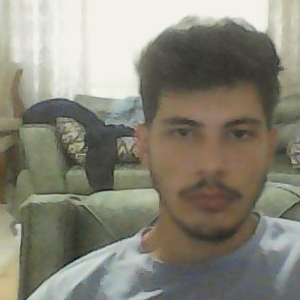

array([[[196, 210, 208],
        [195, 209, 207],
        [190, 206, 202],
        ...,
        [169, 195, 193],
        [166, 191, 190],
        [163, 190, 189]],

       [[198, 211, 209],
        [195, 209, 207],
        [191, 207, 203],
        ...,
        [168, 192, 195],
        [164, 191, 192],
        [161, 189, 188]],

       [[198, 211, 209],
        [196, 210, 208],
        [191, 207, 203],
        ...,
        [169, 193, 196],
        [164, 191, 192],
        [161, 189, 190]],

       ...,

       [[139, 184, 201],
        [139, 184, 201],
        [139, 184, 201],
        ...,
        [109, 101,  95],
        [109, 101,  94],
        [110, 102,  95]],

       [[139, 184, 201],
        [139, 184, 201],
        [139, 184, 201],
        ...,
        [108, 100,  94],
        [109, 101,  94],
        [110, 102,  95]],

       [[139, 182, 203],
        [138, 181, 202],
        [138, 181, 202],
        ...,
        [105,  99,  93],
        [108, 100,  94],
        [110, 102,  96]]], dtype=uint8)
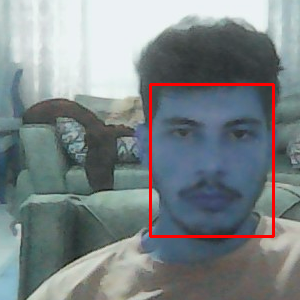

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(augmented["image"])
cv2.rectangle(augmented["image"],tuple(np.multiply(augmented["bboxes"][0][:2], [300,300]).astype(int)),
              tuple(np.multiply(augmented["bboxes"][0][2:], [300,300]).astype(int)), (255,0,0),2)


## Generating Augmented Data
It makes 40 augmention for each image and each labels

In [ ]:
for partition in ["train","test","val"]:
    for image in os.listdir(os.path.join("data",partition,"images")):
        img = cv2.imread(os.path.join("data",partition,"images",image))
        coords = [0,0,0.00001,0.0001]
        label_path = os.path.join("data",partition,"labels",f"{image.split('.')[0]}.json")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = json.load(f)
            coords[0] = label["shapes"][0]["points"][0][0]
            coords[1] = label["shapes"][0]["points"][0][1]
            coords[2] = label["shapes"][0]["points"][1][0]
            coords[3] = label["shapes"][0]["points"][1][1]
            coords = list(np.divide(coords,[640,360,640,360]))
        try:
            for x in range(40):
                augmented = augmentor(image = img, bboxes = [coords], class_labels = ["Semih"])
                cv2.imwrite(os.path.join("aug_data",partition, "images", f"{image.split('.')[0]}.{x}.jpg"),augmented["image"])
                annotation = {}
                annotation["image"] = image
                if os.path.exists(label_path):
                    if len(augmented["bboxes"]) == 0:
                        annotation["bbox"] = [0,0,0,0]
                        annotation["class"] = 0
                    else:
                        annotation["bbox"] = augmented["bboxes"][0]
                        annotation["class"] = 1
                else:
                    annotation["bbox"] = [0,0,0,0]
                    annotation["class"] = 0
                with open(os.path.join("aug_data", partition, "labels", f"{image.split('.')[0]}.{x}.json"), "w") as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

' for partition in ["train","test","val"]:\n\n    for image in os.listdir(os.path.join("data",partition,"images")):\n        img = cv2.imread(os.path.join("data",partition,"images",image))\n        coords = [0,0,0.00001,0.0001]\n        label_path = os.path.join("data",partition,"labels",f"{image.split(\'.\')[0]}.json")\n        if os.path.exists(label_path):\n            with open(label_path, "r") as f:\n                label = json.load(f)\n            coords[0] = label["shapes"][0]["points"][0][0]\n            coords[1] = label["shapes"][0]["points"][0][1]\n            coords[2] = label["shapes"][0]["points"][1][0]\n            coords[3] = label["shapes"][0]["points"][1][1]\n            coords = list(np.divide(coords,[640,360,640,360]))\n        try:\n            for x in range(40):\n                augmented = augmentor(image = img, bboxes = [coords], class_labels = ["Semih"])\n                cv2.imwrite(os.path.join("aug_data",partition, "images", f"{image.split(\'.\')[0]}.{x}.jp

# Resizing and Standarizing Images

In [ ]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
train_images = tf.data.Dataset.list_files("aug_data/train/images/*.jpg", shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files("aug_data/test/images/*.jpg", shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files("aug_data/val/images/*.jpg", shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

array([[[0.37965685, 0.51691175, 0.35220587],
        [0.38357842, 0.52181375, 0.36740196],
        [0.38333333, 0.527451  , 0.39289215],
        ...,
        [0.34705883, 0.49019608, 0.45      ],
        [0.34485295, 0.4997549 , 0.45661765],
        [0.3362745 , 0.5009804 , 0.4617647 ]],

       [[0.39411765, 0.5352941 , 0.36078432],
        [0.39215687, 0.5372549 , 0.36764705],
        [0.37941176, 0.52818626, 0.3629902 ],
        ...,
        [0.35661766, 0.50759804, 0.46642157],
        [0.35441175, 0.5112745 , 0.46862745],
        [0.3480392 , 0.5132353 , 0.4659314 ]],

       [[0.38431373, 0.5254902 , 0.3509804 ],
        [0.37254903, 0.52156866, 0.3372549 ],
        [0.37156862, 0.5235294 , 0.34068626],
        ...,
        [0.34387255, 0.5036765 , 0.47132352],
        [0.34460783, 0.5088235 , 0.46985295],
        [0.34509805, 0.5176471 , 0.46666667]],

       ...,

       [[0.90416664, 1.        , 0.9492647 ],
        [0.8666667 , 0.9892157 , 0.91568625],
        [0.8303922 , 0

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding = "utf-8") as f:
        label = json.load(f)
    return [label["class"]], label["bbox"]

In [ ]:
train_labels = tf.data.Dataset.list_files("aug_data/train/labels/*.json", shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files("aug_data/test/labels/*.json", shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files("aug_data/val/labels/*.json", shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.384 , 0.1409, 0.794 , 0.649 ], dtype=float16))

In [ ]:
len(val_images),len(train_labels)

(160, 1160)

## Preparing the separated datas

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(160)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

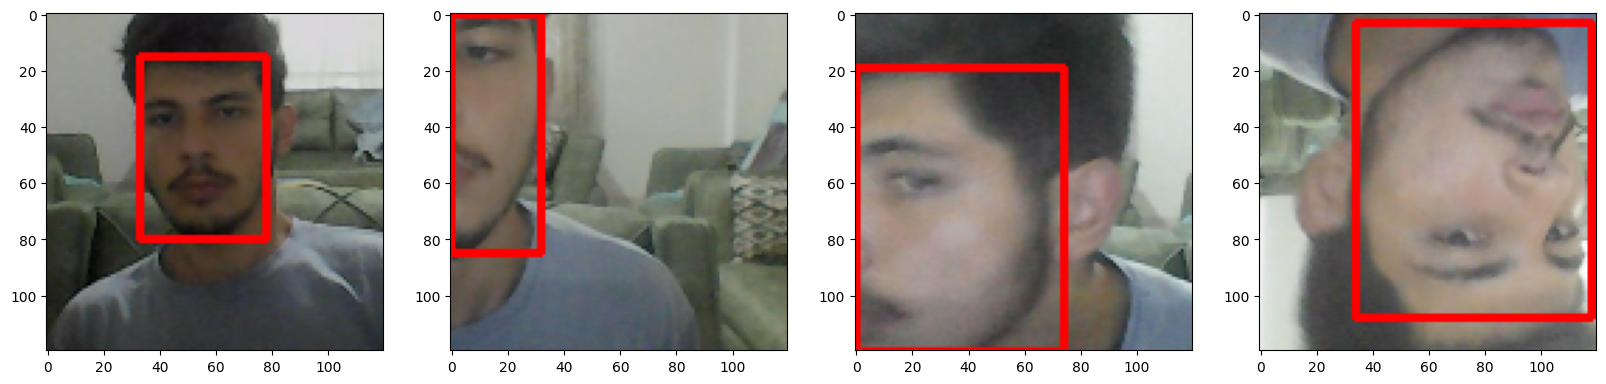

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    cv2.rectangle(sample_image,tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), (255,0,0),2)
    ax[idx].imshow(sample_image)

## Establishing the Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalMaxPool2D, ReLU, Add
from tensorflow.keras.applications import VGG16

In [ ]:
def build_model():
    input_layer = Input(shape = (120,120,3))
    vgg = VGG16(include_top = False)(input_layer)
    f1 = GlobalMaxPool2D()(vgg)
    class1 = Dense(2048, activation = "relu")(f1)
    class2 = Dense(1, activation = "sigmoid")(class1)

    f2 = GlobalMaxPool2D()(vgg)
    regress1 = Dense(2048, activation = "relu")(f2)
    regress2 = Dense(4, activation = "sigmoid")(regress1)

    facetracker = Model(input_layer, outputs = [class2, regress2])
    return facetracker

In [ ]:
facetracker = build_model()
facetracker.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_9[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_8 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

# Localization Loss


In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## Setup Training and Test loss

In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

# Fitting and Predictions

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt,classloss,regressloss)

In [ ]:
logdir = "logs"

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
145/145 [==============================] - 778s 5s/step - total_loss: 1.1715 - class_loss: 0.2133 - regress_loss: 1.0649 - val_total_loss: 1.1233 - val_class_loss: 0.1910 - val_regress_loss: 1.0278
Epoch 2/10
145/145 [==============================] - 723s 5s/step - total_loss: 0.3655 - class_loss: 0.0744 - regress_loss: 0.3283 - val_total_loss: 0.2562 - val_class_loss: 0.0326 - val_regress_loss: 0.2398
Epoch 3/10
145/145 [==============================] - 705s 5s/step - total_loss: 0.2897 - class_loss: 0.0593 - regress_loss: 0.2601 - val_total_loss: 0.4506 - val_class_loss: 0.0962 - val_regress_loss: 0.4026
Epoch 4/10
145/145 [==============================] - 719s 5s/step - total_loss: 0.2174 - class_loss: 0.0451 - regress_loss: 0.1949 - val_total_loss: 0.2213 - val_class_loss: 0.0398 - val_regress_loss: 0.2014
Epoch 5/10
145/145 [==============================] - 703s 5s/step - total_loss: 0.1421 - class_loss: 0.0306 - regress_loss: 0.1268 - val_total_loss: 0.6205 - val_c

# Visualiziging Loss

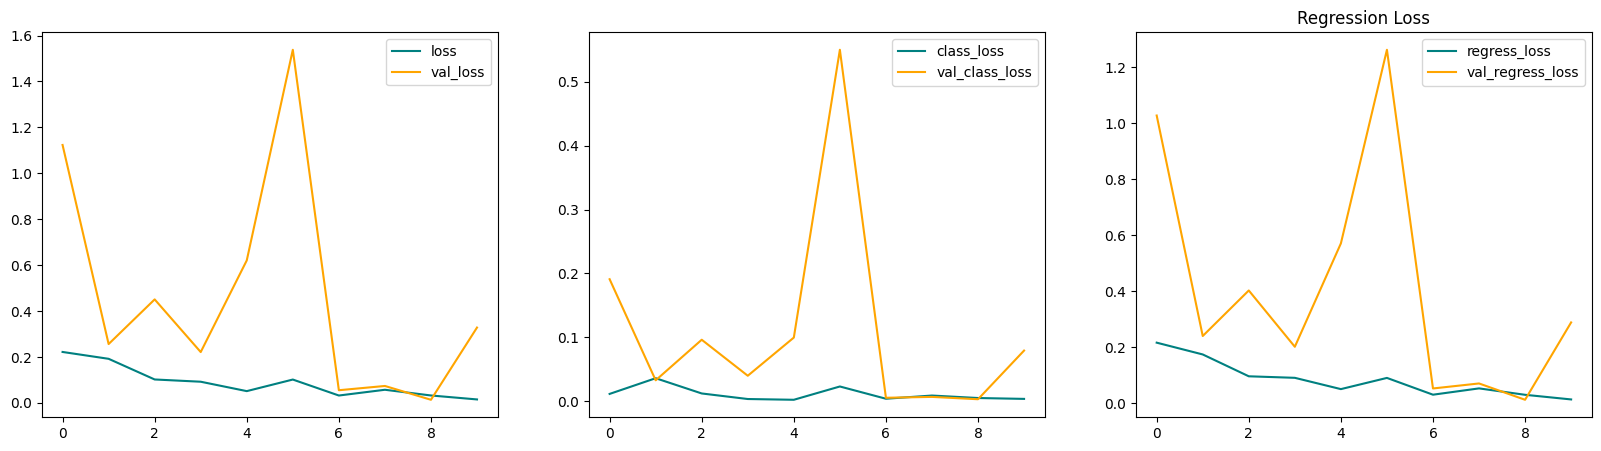

In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize = (20,5))

ax[0].plot(hist.history["total_loss"], color = "teal", label = "loss")
ax[0].plot(hist.history["val_total_loss"], color = "orange", label = "val_loss")
ax[0].legend()

ax[1].plot(hist.history["class_loss"], color = "teal", label = "class_loss")
ax[1].plot(hist.history["val_class_loss"], color = "orange", label = "val_class_loss")
ax[1].legend()

ax[2].plot(hist.history["regress_loss"], color = "teal", label = "regress_loss")
ax[2].plot(hist.history["val_regress_loss"], color = "orange", label = "val_regress_loss")
ax[2].title.set_text("Regression Loss")
ax[2].legend()
plt.show()

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


In [ ]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


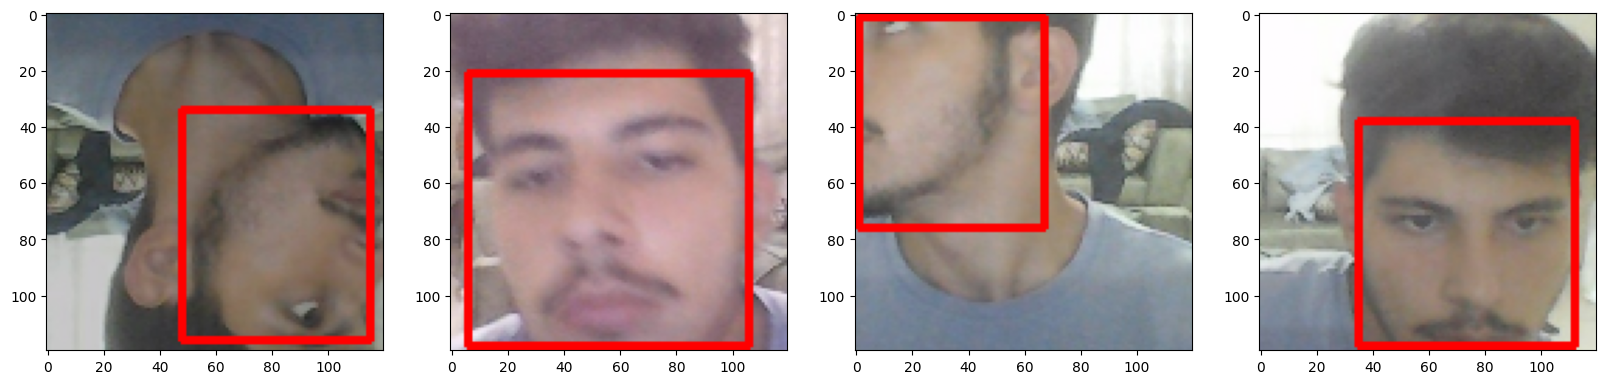

In [ ]:
fig,ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image,tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model
facetracker.save("facetracker.h5")
facetracker = load_model("facetracker.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
